In [37]:
import os
import cv2
import numpy as np
import tensorflow as tf   
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def carica_immagini(cartella):
    immagini = []
    etichette = []
    mappa_etichette = {}
    contatore_etichette = 0
    
    for dircorrente, sottodir, files in os.walk(cartella):  #iteriamo attraverso tutte le directory del nostro os e per ciascun filename in files, se finisce con quella estensione,
        for filename in files:                                   #esso unisce la directory corrente con quella di quel filename, e grazie ad opencv riusciamo a leggere l'img, che viene
            if filename.endswith((".jpg", ".png", ".jpeg")):       #restituita come array, se l'img è letta correttamente, modifichiamo la sua shape in 224 x 224 e aggiungiamo l'img alla lista
                percorso_immagine = os.path.join(dircorrente, filename)    #immagini creata all'inizio
                img = cv2.imread(percorso_immagine)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    immagini.append(img)
                    
                    etichetta = os.path.basename(dircorrente)               #più o meno la stessa cosa, solo che estraiamo la directory corrente, che diventa appunto il nome dell'etichetta,
                    if etichetta not in mappa_etichette:                    #se essa non è già presente nel dizionario mappa_etichette, viene aggiunto e viene utilizzato un contatore
                        mappa_etichette[etichetta] = contatore_etichette    #per le prossime etichette da aggiungere, infine le aggiungiamo alla lista creata all'inizio
                        contatore_etichette += 1
                    etichette.append(mappa_etichette[etichetta])
    
    return np.array(immagini), np.array(etichette), mappa_etichette          #restituisce entrambi le liste e le converte in due array np


train_folder_path = 'C:/Users/EmanueleMiranda/Downloads/ESAME DL DATASET 10k/train'    #indichiamo le directory di tutte e tre le fold con le img di train,valid e test
validation_folder_path = 'C:/Users/EmanueleMiranda/Downloads/ESAME DL DATASET 10k/valid'
test_folder_path = 'C:/Users/EmanueleMiranda/Downloads/ESAME DL DATASET 10k/test'

train_images, train_labels, label_map = carica_immagini(train_folder_path)             #richiamiamo la nostra funzione per caricare effettivamente le nostre img dalle rispettive fold
validation_images, validation_labels, _ = carica_immagini(validation_folder_path)
test_images, test_labels, _ = carica_immagini(test_folder_path)


print(f"Numero di immagini di training caricate: {len(train_images)}")                 #restituisce rispettivamente i valori di img train caricate, img valid caricate, img test caricate,
print(f"Numero di immagini di validation caricate: {len(validation_images)}")           #etichette presenti, mappa indice etichette(0F e 1M) 
print(f"Numero di immagini di test caricate: {len(test_images)}")
print(f"Labels: {train_labels}")
print(f"Label map: {label_map}")


def preprocess_images(images, size=(128, 128)):          #definiamo la nostra funzione con argomenti la lista images da ridimensionare e la grandezza, creiamo una lista con le img processate,
    processed_images = []                            #e per ogni img nella lista images, con opencv facciamo il resize utilizzando quella grandezza, poi lo normalizziamo dividendo per 255 e 
    for img in images:                             #aggiungiamo l'img alla lista di processed creata prima, per poi restituire tale lista come array
        img = cv2.resize(img, size)
        img = img / 255.0
        processed_images.append(img)
    return np.array(processed_images)

train_images = preprocess_images(train_images)            #Qui chiamiamo la funzione preprocess_images creata prima per preprocessare rispettivamente le immagini di training (train_images), 
validation_images = preprocess_images(validation_images)  #di validazione (validation_images) e di test (test_images),ciascuna chiamata restituisce un array di img preprocessate che sovrascrive 
test_images = preprocess_images(test_images)              #le variabili originali (train_images, validation_images, test_images).
 
X_train, y_train = train_images, train_labels         #qui prepariamo le img preprocessate del nostro train set(x_train),le etichette sempre del train set(y_train), e assegniamo ad esse le nostre
X_val, y_val = validation_images, validation_labels    #train images e labels, e facciamo la stessa cosa con il resto 
X_test, y_test = test_images, test_labels



Numero di immagini di training caricate: 7000
Numero di immagini di validation caricate: 2000
Numero di immagini di test caricate: 1000
Labels: [0 0 0 ... 1 1 1]
Label map: {'Female': 0, 'Male': 1}


In [38]:

def create_model(input_shape, num_classes):      #creiamo un modello definendo come aargomenti la dimensioni degli input e il numero di classi, modello seuquentiale di tf, con tutti i possibili
    model = Sequential([                          #parametri da aggiungere quali: strato bidimensionale, maxpooling,altro strato bidimensionale con il doppio di kernel,altro maxpooling, flatten
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),   #per ridimensionare il nostro strato2D in vettore 1D, che ci permetti di passare agli strati densi, aggiunto pure il
        MaxPooling2D((2, 2)),                                  #dropout per evitare overfitting, e softmax come funzione di attivazione finale per calcolare le probabilità che l'input
        Conv2D(64, (3, 3), activation='relu'),         #appartenga ad una classe piuttosto che ad un'altra. nelle altre ho usato la relu come func. attivazione
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')         #compilo il modello con ottimizzatore adam, usando come funzione di perdita quella della crossentropy e come metrica l'accuracy
    ])                        
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)       #dimensione input 128x128 con 3 canali RGB, poi calcolo il numero di classi  contando con la funzione len le etichette presenti nella label_map e infine 
num_classes = len(label_map)           #richiamo il modello sequential della nostra rete CNN creato all'inizio
model = create_model(input_shape, num_classes)

c:\Users\EmanueleMiranda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [39]:

kfold = KFold(n_splits=5, shuffle=True, random_state=42)   #uso la k-fold con argomenti i numeri di fold da creare, facendo un mix dei dati(quindi di img per ridurre la varianza) e usando
kf_accuracies = []                                #il random state per generare numeri casuali, infine creo lista per memorizzare accuracy e loss di tutti i fold
kf_losses = []

for train_index, val_index in kfold.split(X_train):        #qua iteriamo dividendo gli indici dei nostri dati di train in indici di dati di train e valid, poi divide i dati(img) di train in
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]  #nei vari fold di train e valid, e la stessa cosa con le etichette 
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    fold_model = create_model(input_shape, num_classes)        #creiamo un nuovo model CNN per il nostro fold corrente e iniziamo l'addestramento del nostro modello per ciascun fold, con 10
    history = fold_model.fit(X_train_fold, y_train_fold, epochs=10, validation_data=(X_val_fold, y_val_fold))  #epoche, per poi usare il fold di valid per la validazione 

    val_loss, val_accuracy = fold_model.evaluate(X_val_fold, y_val_fold, verbose=0)    #qui valutiamo il modello sul fold di validation, che ci restituisce i valori di loss e accuracy, ed essi
    kf_losses.append(val_loss)                                                          #poi li aggiungiamo alle liste create all'inizio, per poi stampare a schermo i valori, compresi quelli 
    kf_accuracies.append(val_accuracy)                                              #della media delle accuracy e le medie della loss

print(f"K-Fold Cross-Validation accuracies: {kf_accuracies}")
print(f"K-Fold Cross-Validation losses: {kf_losses}")
print(f"Mean accuracy: {np.mean(kf_accuracies)}, Mean loss: {np.mean(kf_losses)}")

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 99s 518ms/step - accuracy: 0.6998 - loss: 0.7782 - val_accuracy: 0.9229 - val_loss: 0.2125
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 90s 515ms/step - accuracy: 0.9342 - loss: 0.1670 - val_accuracy: 0.9357 - val_loss: 0.1675
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 87s 495ms/step - accuracy: 0.9664 - loss: 0.0949 - val_accuracy: 0.9371 - val_loss: 0.1842
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 90s 511ms/step - accuracy: 0.9786 - loss: 0.0582 - val_accuracy: 0.9500 - val_loss: 0.1673
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 86s 489ms/step - accuracy: 0.9908 - loss: 0.0297 - val_accuracy: 0.9436 - val_loss: 0.1915
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 86s 489ms/step - accuracy: 0.9905 - loss: 0.0272 - val_accuracy: 0.9293 - val_loss: 0.2593
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 476ms/step - accuracy: 0.9911 - loss: 0.0295 - val_accuracy: 0.9457 - val_loss: 0.2249
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 473ms/step - accuracy: 0.9967 - loss: 0

In [40]:

final_model = create_model(input_shape, num_classes)        #creiamo una nuova istanza del modello, poi create_model (funzione) definisce l'architettura della CNN e restituisce
history = final_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))  #un modello compilato, per poi fare il training finale con 20 epoche. con la history memorizziamo i dati 
                                                                                     #storici del nostro train

loss, accuracy = final_model.evaluate(X_test, y_test)                 #qua valutiamo i dati e le etichette del nostro modello finale, che ci restituisce la loss e l'accuracy e le stampiamo
print(f'Test accuracy: {accuracy}')

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 435ms/step - accuracy: 0.6900 - loss: 0.8146 - val_accuracy: 0.9285 - val_loss: 0.2050
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 91s 416ms/step - accuracy: 0.9224 - loss: 0.1923 - val_accuracy: 0.9310 - val_loss: 0.1878
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 89s 408ms/step - accuracy: 0.9539 - loss: 0.1230 - val_accuracy: 0.9320 - val_loss: 0.1718
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 139s 393ms/step - accuracy: 0.9708 - loss: 0.0788 - val_accuracy: 0.9440 - val_loss: 0.1732
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 439ms/step - accuracy: 0.9825 - loss: 0.0465 - val_accuracy: 0.9365 - val_loss: 0.2150
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 89s 408ms/step - accuracy: 0.9873 - loss: 0.0325 - val_accuracy: 0.9485 - val_loss: 0.2003
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 89s 406ms/step - accuracy: 0.9927 - loss: 0.0235 - val_accuracy: 0.9460 - val_loss: 0.2385
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 410ms/step - accuracy: 0.9917 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


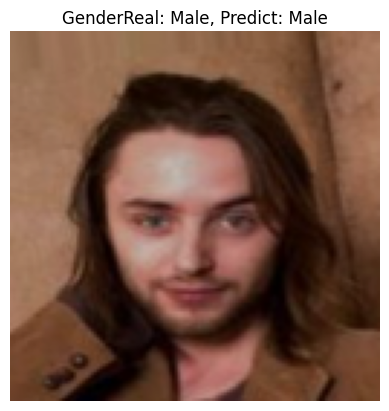

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


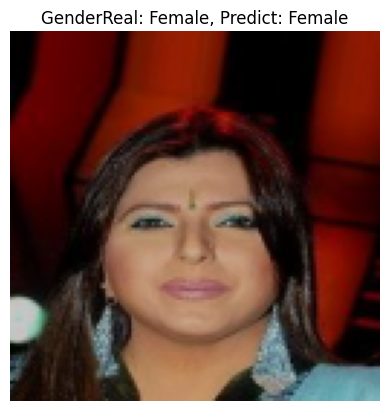

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


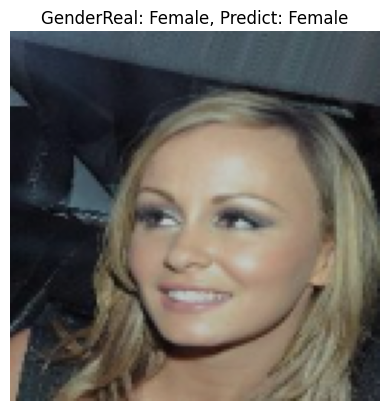

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


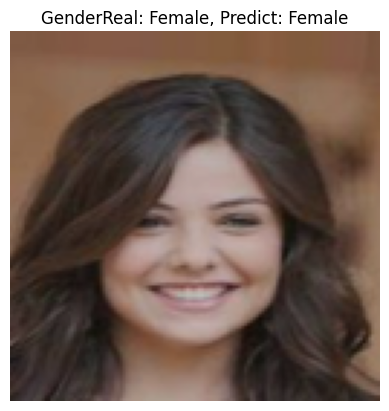

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


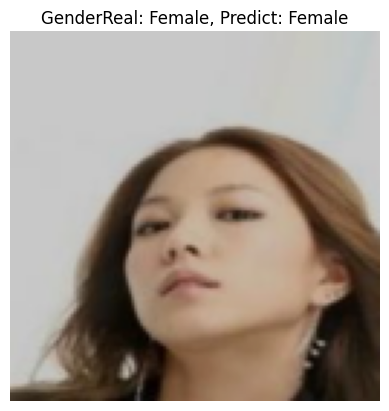

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


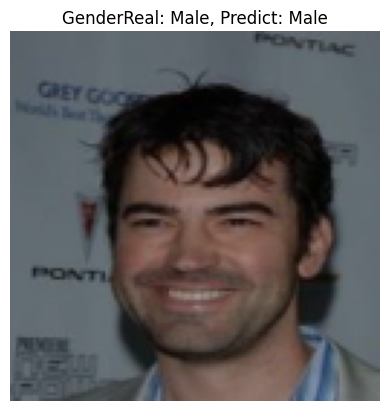

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


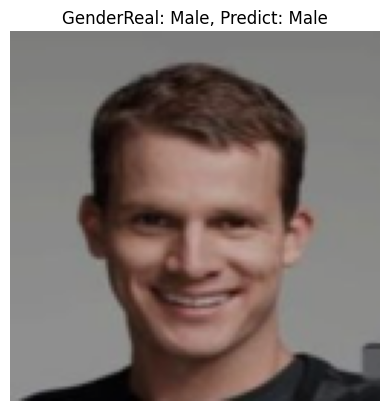

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


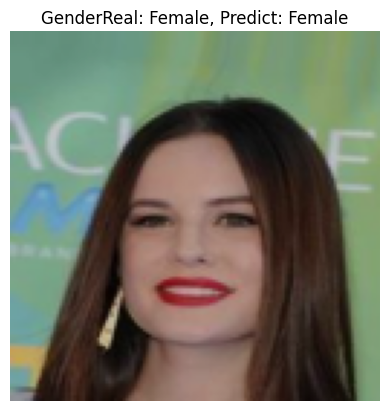

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


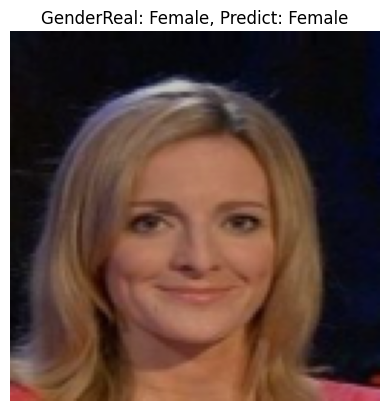

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


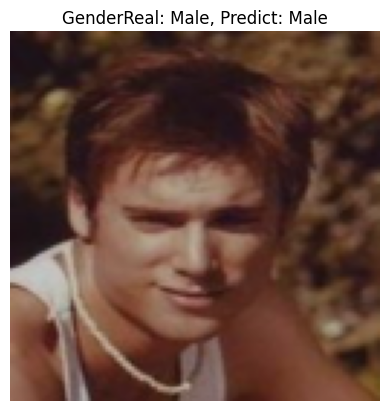

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


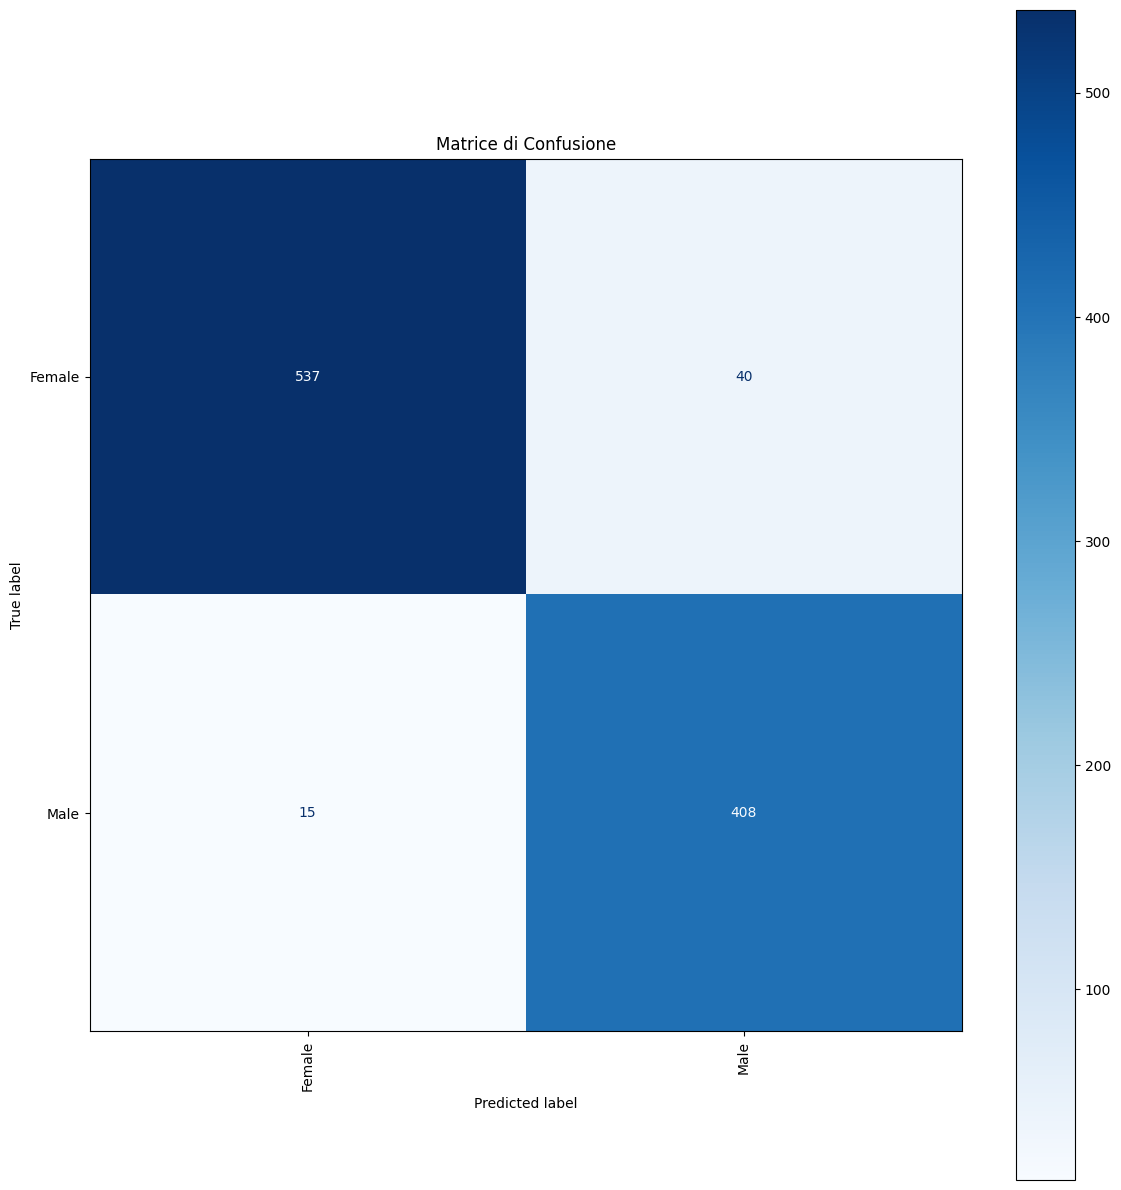

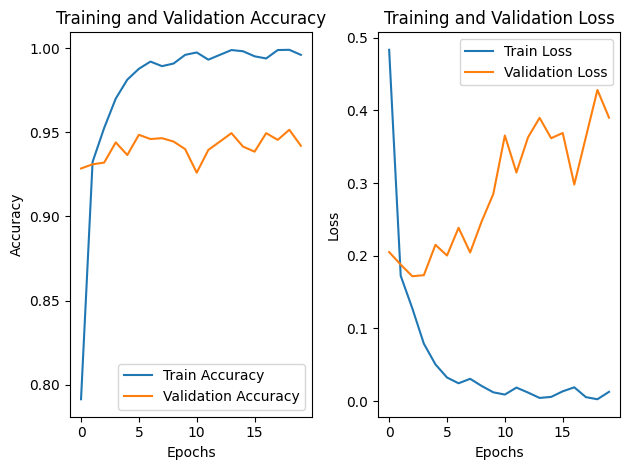

In [43]:

num_images_to_display = 10                             # numero di immagini da visualizzare, facciamo una random e selezioniamo 10 indici casuali dal test set senza sostituzione
random_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

class_labels = list(label_map.keys())   #creiamo una lista con le etichette delle classi

for idx in random_indices:   #iteriamo con un for ogni indice casuale selezionato, e per ognuno di essi recuperiamo l'img, l'etichetta, per poi fare una predict, aggiungendo una shape al'img 
    img = X_test[idx]       #per adattarla al modello, ed infine otteniamo l'indice della classe predetta dal modello
    true_label = y_test[idx]

    pred = final_model.predict(np.expand_dims(img, axis=0))
    pred_label = np.argmax(pred)
    
    plt.imshow(cv2.cvtColor((img * 200).astype(np.uint8), cv2.COLOR_BGR2RGB))        #qua adattiamo l'img per adattarla agli standard RGB, poi impostiamo il titolo della nostra img con la predict
    plt.title(f'GenderReal: {class_labels[true_label]}, Predict: {class_labels[pred_label]}')  #e la vera classe, poi eliminiamo gli assi e mostriamo l'img
    plt.axis('off')
    plt.show()


# Matrice di confusione
y_pred = final_model.predict(X_test)      #facciamo le predizioni su tutto il test set, le convertiamo in etichette di classe e creiamo la matrix confusion con le due classi(pred e real)
y_pred_classes = np.argmax(y_pred, axis=1)  

cm = confusion_matrix(y_test, y_pred_classes)   
labels_subset = {index: name for name, index in label_map.items() if index in np.unique(np.concatenate((y_test, y_pred_classes)))}
                                                #troviamo gli indici delle classi presenti nelle etichette(reali e predette) e creiamo una figura e un asse di subplot con dimensioni specificate
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_subset.values())) #qua creiamo l'oggetto del cm per visualizzarlo, poi la disegniamo con colore Blue e ruotiamo
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical') 

plt.title('Matrice di Confusione') #definiamo il titolo, evitiamo la sovrapposizione di oggetti e scritte e mostriamo la cm
plt.tight_layout()
plt.show()

# Plot delle metriche di training e validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
